# Evaluating CTSM Simulations at NEON Tower Sites -- Tutorial 

This tutorial is an introduction to evaluating CTSM at NEON tower sites.  It will provides example evaluation of the simulation results against NEON tower observations.  

***
**The tutorial uses a Jupyter Notebook.** A Jupyter Notebook is an interactive computing environment that enables the creation and sharing of documents that contain discrete cells of text or documentation and executable code, including plots. It allows users to access, run, and edit the code in a browser. To interact with this notebook:

- Execute or "run" cells of executable code (cells denoted with '[ ]:') using the play button in the menu at the top (see below image)

- The results of running code, such as plots, will appear below that cell

- Each step must be followed in order, otherwise you may encounter errors

![run cell](https://problemsolvingwithpython.com/02-Jupyter-Notebooks/images/run_cell.png)

For more information on Jupyter notebooks please see their [user guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html). 

***

## In this tutorial

The tutorial has several components. Below you will find steps to: 
1. Explore CTSM model data
1. Explore NEON observation data
1. Compare CTSM and NEON latent heat flux data

________
<h2> 1. Explore CTSM model data </h2>

Now that your simulation completed, we can explore the data.
There are countless ways of analyzing and processing model data. This tutorial uses matplotlib. 
***

First, set the NEON site that you ran in the cell below.

*The tutorial is currently set to use the ABBY site. If you ran a simulation for a different tower, please change the 4-character site name in quotes below to the same as your simulation.*

In [1]:
#Change the 4-character NEON site below.
neon_site = "ABBY"

<h4> 1.1 Locate model data </h4>
When the simulation completed, the data are transferred to the `archive` directory. There are files that include data for every day of the simulation, as well as files that average model variables monthly. <p>

*Run the code below to see a subset of the files listed.*

In [2]:
!ls ~/archive/$site.transient/lnd/hist/*2018*.nc |head -20

ls: cannot access '/home/user/archive/.transient/lnd/hist/*2018*.nc': No such file or directory


The list includes the file path and file names.

The file names are automatically generated and include
* the simulation name, which includes
    * the NEON site
    * the type of simulation (here the simulation is "transient", meaning the model ran for the full length of available data)
* the date of simulated data

The files are saved in netcdf format (denoted with the `.nc` file extension), a file format commonly used for storing large, multi-dimensional scientific variables.
Netcdf files are platform independent and self-describing; each file includes metadata that describes the data, including: **variables**, **dimensions**, and **attributes**.

The NEON tower simulations generate two types of files:
* `*h0*`: Variables that are averaged monthly. One file is available for every month of the simulation.
* `*h1*`: Variables that are recorded every 30 minutes. Values are aggregated into one file for each day of the simulation. Each file includes 48 data points.
****


<h4>1.2 Preprocess and Explore Model Simulation Data </h4>

This step has several components, which are broken into smaller steps


<h5>1.2.1 Load Python Libraries</h5>

*Run the below code to import the required python libraries*

In [3]:
## TODO: clean up imports
#Import Libraries
%matplotlib inline

import os
import sys
import glob
import time
import argparse
import requests

import numpy as np
import pandas as pd
import xarray as xr


from glob import glob
from os.path import join, expanduser

import matplotlib
import matplotlib.pyplot as plt

from scipy import stats


<h5>1.2.2 Select Simulation Year</h5>

For simplicity, we focus on analyzing and evaluating a single year of data. <p>

The code below uses data for **2018**, but data are available through this year. You can select a different year by changing the year in the quotes below. <p> 
*Run the below code to identify the year of interest for making the plots. Note that the same year will be used to download observational data below*

In [5]:
#Specify the year below
year = "2018"

#Reading in the tower site selected above as a python variable
#neon_site = os.environ['site']

<h5>1.2.3 Load model data files</h5>

For reading the netCDF files, we are using the `xarray` Python package. You can learn more about [xarray on this website](http://xarray.pydata.org/en/stable/).

The variable `sim_path` points to the location where simulation data are stored. *If you changed the simulation location in the above code, please also update this path.*

*Run the code below to load the model data files. Note that the code will print how many files were loaded*

In [6]:
sim_path = "/home/user/archive/"+neon_site+".transient/lnd/hist/"
sim_files = sorted(glob(join(sim_path,neon_site+".transient.clm2.h1."+year+"*.nc")))

print("All Simulation files: [", len(sim_files), "files]")
#print(*sim_files,sep='\n')

All Simulation files: [ 365 files]


<h5> 1.2.4 Open model data files </h5>

Here we use the python function `xarray.open_mfdataset`, which opens multiple netcdf files as a single xarray dataset. For more information on this function, check [this link](
http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html).

*Run the below cell to read in the data files. Note that this step might take a few minutes.*

In [7]:
start = time.time()

ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, combine='by_coords',parallel=True)

end = time.time()
print("Reading all simulation files took:", end-start, "s.")


Reading all simulation files took: 186.58356618881226 s.


<h5> 1.2.5 Optional Step: Explore simulation data </h5>

*Run the below cell to find more information about the data*

In [8]:
ds_ctsm

,Array,Chunk
Bytes,140.16 kB,768 B
Shape,"(17520,)","(96,)"
Count,5099 Tasks,364 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,140.16 kB,768 B
Shape,"(17520,)","(96,)"
Count,5099 Tasks,364 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


Here you can click on `Data Variables`, `Attributes`, `Deminsions`, and `coordinates` to expand and see the details. 

If you click on `Data Variables`, you will see a list of all the available variables. You can click on each variable to see a description of the variable (the `long_name`) and its `units`, as well as other information. Here are two questions to consider:

**Questions to consider** 
1. What are the avaibale variables in the dataset?
2. What is the `long_name` and `unit` of the variable `FSH`? 
3. Can you find the dimensions of this variable? 

**Tip**: Xarray has built-in plotting functions. For quick inspection of a variable, we can use `.plot()` to see it. Below, let's make a quick plot of the Gross Primary Production (`GPP`) variable:

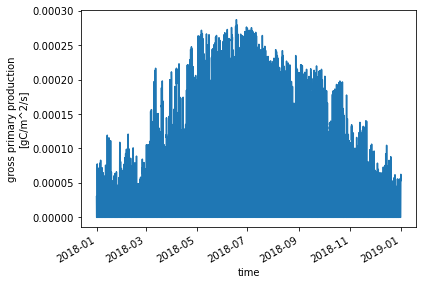

In [9]:
ds_ctsm['GPP'].plot()

________
<h2> 2. Explore NEON Tower Observation Data </h2>

<h4> 2.1 Load NEON data </h4>
    
The following code will download the NEON observational data files for the site and year specified above. 

*Run the two cells of code below. You will see what files are available.*

In [10]:
eval_dir = "/home/user/evaluation_files/"

download_eval_files(neon_site, eval_dir)

eval_path = os.path.join('/home/user/evaluation_files/',neon_site)

eval_files = sorted(glob(join(eval_path,neon_site+"_eval_"+year+"*.nc")))

print("All Observation files:")
print(*eval_files,sep='\n')

NameError: name 'download_eval_files' is not defined

In [ ]:
start = time.time()

ds_eval = xr.open_mfdataset(eval_files, decode_times=True, combine='by_coords')

end = time.time()
print("Reading all observation files took:", end-start, "s.")

<h4> 2.2 Optional Step: Explore NEON data </h4>

Similar to above, you can explore NEON data by clicking to see details about the variables, coordinate, and attributes.

In [ ]:
ds_eval

Let's quickly inspect the Net Radiation (`Rnet`) variable by making a simple plot:

In [ ]:
ds_eval['Rnet'].plot()

__________
# 3. Compare CTSM and NEON latent heat flux data

So far we read files of observational and model data. In this section we will compare observed and simulated **latent heat fluxes**. You can also explore other available variables with this code.
***

#### Format Data
The next cell of code processes the data into a common format to make analysis easier. 

*Run the below cell of code*

In [ ]:
#Negin will clean up this code a little bit

#Convert CTSM data to a Pandas Dataframe for easier handling:
plot_vars = ['FCEV', 'FCTR', 'FGEV']

df_ctsm = pd.DataFrame({'time':ds_ctsm.time})

for var in plot_vars:
    field = np.ravel ( ds_ctsm[var])     
    df_ctsm[var]=field

#Convert NEON data to a Pandas Dataframe for easier handling:
eval_vars = ['EFLX_LH_TOT']

df_eval = pd.DataFrame({'time':ds_eval.time})

for var in eval_vars:
    field = np.ravel ( ds_eval[var])     
    df_eval[var]=field

#-- extract year, month, day, hour information from time
df_eval['year'] = df_eval['time'].dt.year
df_eval['month'] = df_eval['time'].dt.month
df_eval['day'] = df_eval['time'].dt.day
df_eval['hour'] = df_eval['time'].dt.hour

#-- make df_all that includes both obs and sim
df_all = df_eval

#-- add simulation data to df_all and adjust for offset time dimension:
for var in plot_vars:
    sim_var_name = "sim_"+var
    #-- shift simulation data by one
    df_all[sim_var_name]=df_ctsm[var].shift(-1).values

### 3.1 What is latent heat flux?

Below we explore how well CTSM simulates latent heat flux, which is directly observed at NEON towers. Latent heat flux is the energy for water evaporation from the ecosystem. Latent heat flux is a combination of plant transpiration, evaporation from leaf surfaces (e.g., from dew, after precipitation events), and evaporation from the soil:

$$ Latent Heat Flux = Transpiration + Canopy Evaporation + Ground Evaporation $$

Although NEON towers cannot distinguish how much each of these processes contributes to latent heat flux, CTSM simulations can help us to disentangle the role of each. 

First we will calculate latent heat flux simulated by CTSM by summing the component fluxes in the above equation. The CTSM variables are:

>$FCEV$: Canopy evaporation (W m<sup>-2</sup>) <br>
>$FCTR$: Canopy transpiration (W m<sup>-2</sup>) <br>
>$FGEV$: Ground evaporation (W m<sup>-2</sup>) <br>

*Run the below cell to calculate simulated latent heat flux*

In [ ]:
clm_var = 'sim_EFLX_LH_TOT'

#EFLX_LH_TOT = FCEV + FCTR +FGEV
df_all [clm_var] = df_ctsm['FCEV'].shift(-1).values \
                 + df_ctsm['FCTR'].shift(-1).values \
                 + df_ctsm['FGEV'].shift(-1).values

### 3.2 Plotting latent heat flux

#### 3.2.1 Plotting Daily Timeseries
First we will create a time-series plot comparing daily average latent heat flux from observation (NEON) and simulations (CTSM). To start, we need calculate the daily averages. 

*Run the below cells of code to calculate daily averages*

In [ ]:
df_daily = df_all.groupby(['year','month','day']).mean().reset_index()
df_daily['time']=pd.to_datetime(df_daily[["year", "month", "day"]])

In [ ]:
plot_var = 'EFLX_LH_TOT'
sim_var = 'sim_'+plot_var

plot_var_desc = "Latent Heat Flux"
plot_var_unit= "Wm-2"

Using the daily averages we calculated, we can create a plot using Python's [matplotlib package:](https://matplotlib.org/)

*Run the below cell to create the plot*

In [ ]:
plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')
        
ax = plt.gca()
df_daily.plot ( x= 'time', y = plot_var , marker = 'o' ,ax =ax , color = 'b',label="NEON")
df_daily.plot ( x= 'time', y = 'sim_'+plot_var , marker = 'o' ,ax =ax , color = 'r',label="CLM")

plt.xlabel('Time', fontsize=17)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)
plt.title(year+" "+neon_site, fontweight='bold',fontsize=17)
plt.show()

Looking at variability gives us an indication of when and where simulations are outside the range of observed values. Let's explore variability by adding the daily standard deviation as a shaded area to the plot:

In [ ]:
df_daily_std = df_all.groupby(['year','month','day']).std().reset_index()
df_daily_std['time'] = pd.to_datetime(df_daily_std[["year", "month", "day"]])

plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')

plt.plot ( df_daily.time, df_daily[plot_var], marker = 'o' , color = 'b',label="NEON")
plt.plot ( df_daily.time, df_daily[sim_var], marker = 'o' , color = 'r',label="CLM")

plt.fill_between(df_daily.time, df_daily.EFLX_LH_TOT-df_daily_std.EFLX_LH_TOT, df_daily.EFLX_LH_TOT+df_daily_std.EFLX_LH_TOT ,alpha=0.1, color = 'b')
plt.fill_between(df_daily.time, df_daily.sim_EFLX_LH_TOT-df_daily_std.sim_EFLX_LH_TOT, df_daily.sim_EFLX_LH_TOT+df_daily_std.sim_EFLX_LH_TOT ,alpha=0.1, color = 'r')

plt.legend()
plt.xlabel('Time', fontsize=17)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)
plt.title(year+" "+neon_site, fontweight='bold',fontsize=17)
plt.show()

This allows us to see when CTSM under-predicts or over-predicts the NEON tower observations.

#### **Questions to consider:**

1. When is the latent heat hlux highest at this site? When is it lowest? <br>
1. Does CLM match NEON tower observations? <br>
1. What times of year does CLM shows the best and worst performance in predicting latent heat flux ? <br>

*****
### 3.2.2 Plotting Monthly Averages & Component Fluxes: Absolute Values

Next we will disentangle whether transpiration, canopy evaporation, or ground evaporation is the dominant contribution to latent heat flux during each month using CTSM data. As mentioned in section 3.1, NEON observations cannot distinguish how much each of these processes contributes to latent heat fluxes. 

*Run the cell below to calculate monthly averages*

In [ ]:
df_monthly = df_all.groupby(['year','month']).mean().reset_index()
df_monthly["day"]=15
df_monthly['time']=pd.to_datetime(df_monthly[["year", "month","day"]])

##### Next we will create a stacked bar chart showing components of latent heat flux over different months

*Run the cell below to create the plot*

In [ ]:
def line_format(label):
    """
    Helper function to convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month


plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')
        
ax = plt.gca()

df_monthly.plot ( x= 'time', y = 'EFLX_LH_TOT' , marker = 'o' ,ax =ax , color = 'black',label="NEON Latent Heat Flux",use_index=False)
df_monthly[['time','sim_FCEV','sim_FCTR','sim_FGEV']].plot.bar ( x= 'time',stacked='True',ax=ax,rot=0)

ax.set_xticklabels(map(line_format, df_monthly.time))

plt.xlabel('Time', fontsize=18)
plt.ylabel('Latent Heat Flux', fontsize=16)
        
plt.title(year+" "+neon_site, fontweight='bold')
plt.show()

The monthly averages of NEON latent heat flux observation are plotted as a line on top of the barplot for reference.

#### **Questions to consider:**

1. Which months does CTSM overestimate and underestimate observed latent heat fluxes for this site? 
1. What times of year is Canopy Transpiration (FCTV) the largest contributor to the total CTSM latent heat flux?
1. What times of year are Canopy Evaporation (FCEV) and Ground Evaporation (FGEV) important contributors to the total CTSM latent heat flux? 
1. What is the dominant component flux when CTSM overestimates observed latent heat fluxes? When CTSM underestimates latent heat fluxes?
****

#### 3.2.3 Plotting Monthly Averages & Component Fluxes: Proportional Contributions
It might be easier to see the proportional contributions of transpiration and evaporation fluxes to total latent heat flux. We can look at a more advanced plot with two y axis that helps to illustrate the absolute values of monthly latent heat fluxes and the proportion of component fluxes each month. 

In [ ]:
df_monthly ['sim_FCEV_perc']= df_monthly ['sim_FCEV']/(df_monthly ['sim_FCEV']+df_monthly ['sim_FCTR']+df_monthly ['sim_FGEV'])*100
df_monthly ['sim_FCTR_perc']= df_monthly ['sim_FCTR']/(df_monthly ['sim_FCEV']+df_monthly ['sim_FCTR']+df_monthly ['sim_FGEV'])*100
df_monthly ['sim_FGEV_perc']= df_monthly ['sim_FGEV']/(df_monthly ['sim_FCEV']+df_monthly ['sim_FCTR']+df_monthly ['sim_FGEV'])*100

plt.figure(num=None, figsize=(13, 7),  facecolor='w', edgecolor='k')
        
ax = plt.gca()

df_monthly[['time','sim_FCEV_perc','sim_FCTR_perc','sim_FGEV_perc']].plot.bar ( x= 'time',stacked='True',ax=ax,rot=0)

ax.set_xticklabels(map(line_format, df_monthly.time))
ax.set_ylabel('% Components Latent Heat Flux', fontsize=16)
ax.legend(bbox_to_anchor=(1.04,0), loc="lower left",labels=["% FCEV","% FCTR","% FGEV"])
ax2 = ax.twinx()
df_monthly.plot ( x= 'time', y = 'sim_EFLX_LH_TOT' , marker = 'o' ,ax =ax2 , color = 'b',label="CLM Latent Heat",use_index=False)
df_monthly.plot ( x= 'time', y = 'EFLX_LH_TOT' , marker = 'o' ,ax =ax2 , color = 'r',label="NEON Latent Heat",use_index=False)

plt.ylabel('Latent Heat Flux [W/m2]', fontsize=16)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.title(year+" "+neon_site, fontweight='bold')
plt.show()

______________

#### 3.2.4 Annual and Seasonal Scatter Plots
Scatter plots can help to describe the relationship between latent heat flux and the component transpiration and evaporation fluxes. Below we plot annual relationships.

*Run the cells below to first define a generic function that plot scatter diagrams and add a regression line, and then to generate the plots.*

In [ ]:
#Defining generic function for scatter plots
def detailed_scatter (x, y, color):
    plt.scatter (x,y, marker="o",color = color)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    plt.plot(x,line,'black', label='y={:.2f}x+{:.2f}'.format(slope,intercept)+" (R2="+"{:.2f}".format(r_value)+")")
    plt.legend(fontsize=13)

In [ ]:
#Generating plots
plt.figure(num=None, figsize=(15, 5),  facecolor='w', edgecolor='k')

plt.subplot(1, 3, 1)
detailed_scatter (df_daily.sim_FCEV, df_daily.sim_EFLX_LH_TOT, '#1f77b4')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(1, 3, 2)
detailed_scatter (df_daily.sim_FCTR, df_daily.sim_EFLX_LH_TOT, '#ff7f0e')

plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')

plt.subplot(1, 3, 3)
detailed_scatter (df_daily.sim_FGEV, df_daily.sim_EFLX_LH_TOT,'#2ca02c')

plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')

plt.suptitle(year+" "+neon_site+" Scatter Plots", fontweight='bold')

plt.tight_layout()
plt.show()

##### Since the relationships between latent heat flux and the component transpiration and evaporation fluxes likely vary throughout the year, we can investigate how the relationships change during different seasons.

*Run the cell below to generate scatter plots by season*

In [ ]:
df_daily['season'] = ((df_daily['month']%12+3)//3).map({1:'DJF', 2: 'MAM', 3:'JJA', 4:'SON'})

fig= plt.figure(num=None, figsize=(18,12),  facecolor='w', edgecolor='k')

season = 'MAM'
df_season =  df_daily[df_daily['season']==season]

plt.subplot(3, 4, 1)
detailed_scatter (df_season.sim_FCEV, df_season.sim_EFLX_LH_TOT, '#1f77b4')
plt.title(season, fontweight='bold')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(3, 4, 5)
detailed_scatter (df_season.sim_FCTR, df_season.sim_EFLX_LH_TOT, '#ff7f0e')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')


plt.subplot(3, 4, 9)
detailed_scatter (df_season.sim_FGEV, df_season.sim_EFLX_LH_TOT,'#2ca02c')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')


season = 'JJA'
df_season =  df_daily[df_daily['season']==season]

plt.subplot(3, 4, 2)
detailed_scatter (df_season.sim_FCEV, df_season.sim_EFLX_LH_TOT, '#1f77b4')
plt.title(season, fontweight='bold')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(3, 4, 6)
detailed_scatter (df_season.sim_FCTR, df_season.sim_EFLX_LH_TOT, '#ff7f0e')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')

plt.subplot(3, 4, 10)
detailed_scatter (df_season.sim_FGEV, df_season.sim_EFLX_LH_TOT,'#2ca02c')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')


season = 'SON'
df_season =  df_daily[df_daily['season']==season]

plt.subplot(3, 4, 3)
detailed_scatter (df_season.sim_FCEV, df_season.sim_EFLX_LH_TOT, '#1f77b4')
plt.title(season, fontweight='bold')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(3, 4, 7)
detailed_scatter (df_season.sim_FCTR, df_season.sim_EFLX_LH_TOT, '#ff7f0e')
plt.ylabel('Latent Heat[Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')

plt.subplot(3, 4, 11)
detailed_scatter (df_season.sim_FGEV, df_season.sim_EFLX_LH_TOT,'#2ca02c')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')

season = 'DJF'
df_season =  df_daily[df_daily['season']==season]

plt.subplot(3, 4, 4)
detailed_scatter (df_season.sim_FCEV, df_season.sim_EFLX_LH_TOT, '#1f77b4')
plt.title(season, fontweight='bold')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(3, 4, 8)
detailed_scatter (df_season.sim_FCTR, df_season.sim_EFLX_LH_TOT, '#ff7f0e')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')

plt.subplot(3, 4, 12)
detailed_scatter (df_season.sim_FGEV, df_season.sim_EFLX_LH_TOT, '#2ca02c')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')

fig.suptitle(year+" "+neon_site+ " Seasonal Scatter Plots", fontweight='bold')
fig.tight_layout()

plt.show()

--------
#### 3.2.5 Average Diel Cycle

Latent heat flux also changes throughout the day. Does CTSM capture the diel cycle that NEON observes? We can compare the average diel cycle from NEON observations and CTSM simulations to find out.

*Run the cells below to calculate the annual average diel cycle and to generate a plot*

In [ ]:
# Calculate annual average diel cycle and bias
diel_df_mean = df_all.groupby('hour').mean().reset_index()
diel_df_std = df_all.groupby('hour').std().reset_index()

diel_df_mean['EFLX_LH_TOT_bias'] = diel_df_mean['sim_EFLX_LH_TOT']- diel_df_mean['EFLX_LH_TOT']
print (diel_df_mean)

In [ ]:
# Plot annual average diel cycle and bias
plt.figure(num=None, figsize=(13, 9),  facecolor='w', edgecolor='k')
        
plt.subplot(2, 1, 1)  
        
plt.plot ( diel_df_mean.hour, diel_df_mean['EFLX_LH_TOT'], marker = 'o' , color = 'b',label="NEON")
plt.plot ( diel_df_mean.hour, diel_df_mean['sim_EFLX_LH_TOT'], marker = 'o' , color = 'r',label="CLM")

plt.fill_between(diel_df_mean.hour, diel_df_mean.EFLX_LH_TOT-diel_df_std.EFLX_LH_TOT, diel_df_mean.EFLX_LH_TOT+diel_df_std.EFLX_LH_TOT ,alpha=0.1, color = 'b')
plt.fill_between(diel_df_mean.hour, diel_df_mean.sim_EFLX_LH_TOT-diel_df_std.sim_EFLX_LH_TOT, diel_df_mean.sim_EFLX_LH_TOT+diel_df_std.sim_EFLX_LH_TOT ,alpha=0.1, color = 'r')
plt.ylabel('Latent Heat Flux [Wm-2]', fontsize=16)

plt.title("Diurnal Cycle of Latent Heat Flux "+neon_site+" "+year, fontweight='bold')
plt.legend()
plt.subplot(4, 1, 3)  

ax = plt.gca()    
diel_df_mean.plot ( x= 'hour', y = 'EFLX_LH_TOT_bias' , marker = 'o' ,ax =ax , color = 'black',label='Bias')
plt.xlabel('Hour', fontsize=18)
plt.ylabel('Bias', fontsize=16)
plt.show()

##### How do contributions from transpiration and evaporation fluxes to latent heat flux change throughout the day? 

*Run the cells below to find out.*

In [ ]:
#Calculating diel cycle flux proportions
diel_df_mean['sim_FCEV_perc']= diel_df_mean ['sim_FCEV']/(diel_df_mean ['sim_FCEV']+diel_df_mean ['sim_FCTR']+diel_df_mean ['sim_FGEV'])*100
diel_df_mean ['sim_FCTR_perc']= diel_df_mean ['sim_FCTR']/(diel_df_mean ['sim_FCEV']+diel_df_mean ['sim_FCTR']+diel_df_mean ['sim_FGEV'])*100
diel_df_mean ['sim_FGEV_perc']= diel_df_mean ['sim_FGEV']/(diel_df_mean ['sim_FCEV']+diel_df_mean ['sim_FCTR']+diel_df_mean ['sim_FGEV'])*100

In [ ]:
#plotting diel cycl flux proportions
from matplotlib import gridspec

fig= plt.figure(num=None, figsize=(13, 10),  facecolor='w', edgecolor='k')

gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 2]) 

ax0 = plt.subplot(gs[0])
        
ax0.plot ( diel_df_mean.hour, diel_df_mean['EFLX_LH_TOT'], marker = 'o' , color = 'b',label="NEON")
ax0.plot ( diel_df_mean.hour, diel_df_mean['sim_EFLX_LH_TOT'], marker = 'o' , color = 'r',label="CLM")

ax0.fill_between(diel_df_mean.hour, diel_df_mean.EFLX_LH_TOT-diel_df_std.EFLX_LH_TOT, diel_df_mean.EFLX_LH_TOT+diel_df_std.EFLX_LH_TOT ,alpha=0.1, color = 'b')
ax0.fill_between(diel_df_mean.hour, diel_df_mean.sim_EFLX_LH_TOT-diel_df_std.sim_EFLX_LH_TOT, diel_df_mean.sim_EFLX_LH_TOT+diel_df_std.sim_EFLX_LH_TOT ,alpha=0.1, color = 'r')
plt.ylabel('Latent Heat Flux [Wm-2]', fontsize=16)
plt.legend()
plt.title("Diurnal Cycle of Latent Heat Flux "+neon_site+" "+year, fontweight='bold')

ax1 = plt.subplot(gs[1])
diel_df_mean.plot ( x= 'hour', y = 'EFLX_LH_TOT_bias' , marker = 'o' ,ax =ax1 , color = 'black',label='Bias')
plt.xlabel('', fontsize=18)
plt.ylabel('Bias', fontsize=16)

ax2 = plt.subplot(gs[2])
diel_df_mean[['hour','sim_FCEV','sim_FCTR','sim_FGEV']].plot.bar ( x= 'hour',stacked='True',ax=ax2,rot=0)
plt.ylabel('%Latent Heat Components', fontsize=16)
plt.xlabel('Hour', fontsize=18)

plt.tight_layout()

fig.show()

## Congratulations! You have:
1. Accessed the CTSM model data
1. Accessed the NEON observational data
1. Evaluated CTSM latent heat fluxes compared to NEON tower observations
1. Determined when transpiration and evaporation fluxes drive latent heat fluxes
1. Learned how to average over different time periods and create different types of plots

#### If you would like to learn more advanced interactive visualization tools, please see the NEON_Evaluation_Advanced.ipynb.
You can also use this script to explore additional CTSM and NEON data by changing the variables in section 3 of this script.


___________________
Negin: Should we remove the soil moisture profile plot if we're including it in the main tutorial visualization? 
If it isn't included there, we can link this to the rest of the tutorial by highlighting that soil moisture is an important control on LH fluxes by controlling available water. Shallow water can be both evaporated and transpired, whereas deeper water will be transpired more than evaporated.

## Soil Profiles:

Now, let's take a look at the soil profile ***** (Ask Danica)



In [ ]:
ds_ctsm.TSOI.isel(levgrnd=(slice(0,9))).plot(x="time",yincrease=False, robust=True,cmap='YlOrRd',figsize=(15, 5))


Cut from above (but may want to add back): 

The figure below provides an example of data strucutre in a netcdf file. For example, this dataset has two variables (temperature and pericipation) stored in three-dimensional variables. It also has three dimensions (x, y, and time) which are one dimensional coordinates. It also includes two-dimensional coordinates (latitude and longitude). 

![Netcdf](https://gdfa.ugr.es/python/climate_data/img/xarray2.png)